# Model

In [107]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from members import Members
from weather import Weather
from expeds import Expeds


# Get Data
member = Members().get_data()
member = Members().clean_data(member)

weather = Weather().get_data()
weather = Weather().clean_data(weather)

exped = Expeds().get_data()
exped = Expeds().clean_data(exped)

# Drop columns
mem_to_drop = ['memb_id','year','unique_id','peak_id','residence','occupation',
'summit_claimed','summit_disputed','highpt','high_point','death','death_type',
'death_height','death_class','summit_term','summit_date1', 'summit_bid',
'citizenship','o2_climb','o2_descent','o2_sleep','o2_medical', 'o2_none', 
'yob', 'route1', 'ascent1', 'leader', 'deputy', 'bconly', 'nottobc', 'support', 
'hired', 'sherpa', 'tibetan']


exp_to_drop = ['year','season','route1','route2','nation','leaders',
'sponsor','success1','success2', 'ascent1','claimed','disputed',
'countries','summit_time','term_date','term_note','high_point',
'traverse','ski','parapente','o2_climb','o2_descent','o2_sleep',
'o2_medical','o2_taken','o2_unkwn','o2_used','o2_none','other_smts',
'campsites','accidents','achievment','agency','peak_name','primmem',
'summiter_deaths','summit_members','summit_hired','hired_deaths']

member.drop(columns= mem_to_drop, inplace=True)
exped.drop(columns= exp_to_drop, inplace=True)

exped['summit_date'] = pd.to_datetime(exped.summit_date, errors = 'coerce')
exped['bc_date'] = pd.to_datetime(exped.bc_date , errors = 'coerce')
exped = exped.set_index('summit_date')
weather = weather.set_index('date_time')

# Feature Engineering (1/2)
exped['sherpa_ratio'] = exped['tot_hired'] / exped['tot_members']
exped['sherpa_ratio'] = np.where(exped['sherpa_ratio'] == np.inf, 0, exped['sherpa_ratio'])

weather['pressure_past'] = weather['pressure'].rolling(window=3).mean()
weather['pressure_futur'] = weather['pressure'].shift(-2).rolling(window=3).mean()
weather['stability'] = weather['pressure_futur'] - weather['pressure_past']

# Merge DataFrames
df = exped.merge(weather, how='left', left_index=True, right_index=True)
df = df.reset_index()
df = df.rename(columns={'index' : 'summit_date'})
df = df.merge(member, on='exp_id', how = 'right')
df.drop(columns=['moonrise', 'moonset', 'sunrise', 'sunset'], inplace = True)
df = df.dropna(subset=['summit_date', 'bc_date'])

# Feature Engineering (2/2)
df['cumul_snow'] = 0

for index, row in df.iterrows():
    date1 = row['bc_date'].date()
    date2 = row['summit_date'].date()
    acc_snow = weather.loc[date1:date2, 'totalSnow_cm'].sum()
    df.loc[index, 'cumul_snow'] = acc_snow

df.drop(columns=['summit_date', 'exp_id', 'bc_date', 'term_reason', 'pressure_past', 'pressure_futur'], inplace=True)

In [108]:
# Columns used for the model
df.columns

Index(['peak_id', 'host', 'summit_days', 'tot_days', 'camps', 'rope',
       'tot_members', 'tot_hired', 'no_hired', 'comrte', 'stdrte', 'primrte',
       'peak_height', 'sherpa_ratio', 'maxtempC', 'mintempC', 'totalSnow_cm',
       'sunHour', 'uvIndex', 'moon_illumination', 'DewPointC', 'FeelsLikeC',
       'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity',
       'precipMM', 'pressure', 'tempC', 'visibility', 'winddirDegree',
       'windspeedKmph', 'stability', 'season', 'sex_M', 'status', 'disabled',
       'summit_success', 'solo', 'traverse', 'ski', 'parapente', 'speed',
       'o2_used', 'age', 'cumul_snow'],
      dtype='object')

In [109]:
# Data Processing
col_num = []
col_bool =[]
col_object =[]

for col in df:
    if df[col].dtype == "float64":
        col_num.append(col)
        
    if df[col].dtype == "int64":
        col_num.append(col)
        
    if df[col].dtype == 'bool':
        col_bool.append(col)
        
    if df[col].dtype == 'object':
        col_object.append(col)
        
col_bool.remove('summit_success')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop= 'first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, col_num),
        ('cat', categorical_transformer, col_object)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])

X = df.drop(columns=['summit_success'])
y = df.summit_success

X_trans = clf.fit_transform(X)
X_tr = X_trans.toarray()

X_train, X_test, y_train, y_test = train_test_split(X_tr, y, test_size= 0.3, random_state= 1)

In [110]:
ohe_col = list(clf.named_steps['preprocessor'].transformers_[1][1]\
   .named_steps['onehot'].get_feature_names(col_object))

feature_names = col_num + ohe_col

In [111]:
# Model Traning
from sklearn.metrics import classification_report
boost = XGBClassifier()
boost.fit(X_train, y_train)
ypred = boost.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

       False       0.85      0.83      0.84      2290
        True       0.79      0.82      0.81      1852

    accuracy                           0.82      4142
   macro avg       0.82      0.82      0.82      4142
weighted avg       0.83      0.82      0.82      4142



In [5]:
# Best model of Jeremy
best_of_best = XGBClassifier(n_estimators = 300,
                            max_depth = 18,
                            learning_rate = 0.3,
                            gamma = 0.8,
                            min_child_weight = 4,
                            colsample_bytree = 0.3
                            )

best_of_best.fit(X_train, y_train)
ypred = best_of_best.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

       False       0.84      0.82      0.83      2290
        True       0.78      0.81      0.79      1852

    accuracy                           0.81      4142
   macro avg       0.81      0.81      0.81      4142
weighted avg       0.81      0.81      0.81      4142



## Features

### Feature Importance

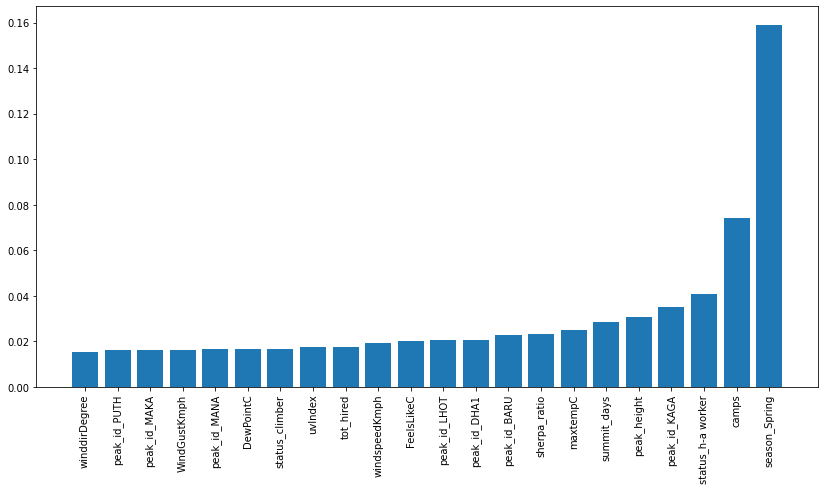

In [112]:
# feature importance
dfeat = pd.DataFrame(data=boost.feature_importances_)
dfeat['feature'] = feature_names
dfeat.columns = ['value', 'feature']
dfeat = dfeat.sort_values(by='value')

val = 0.015
# plot
plt.bar(dfeat.loc[dfeat['value']> val , 'feature'], dfeat.loc[dfeat['value']> val , 'value'])
plt.xticks(rotation=90)
plt.show()

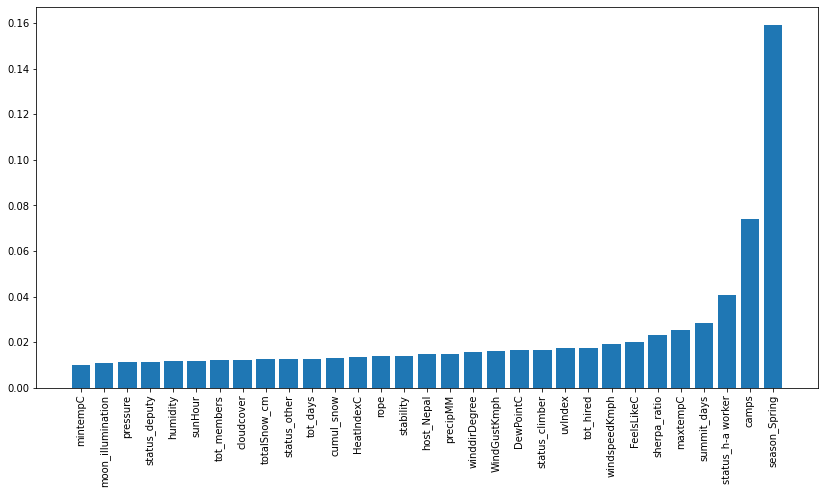

In [117]:
# feature without peak_id
df_feat_2 = dfeat[~dfeat['feature'].str.contains('peak')]

# plot
val = 0.01

plt.bar(df_feat_2.loc[df_feat_2['value']> val , 'feature'], df_feat_2.loc[df_feat_2['value']> val , 'value'])
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

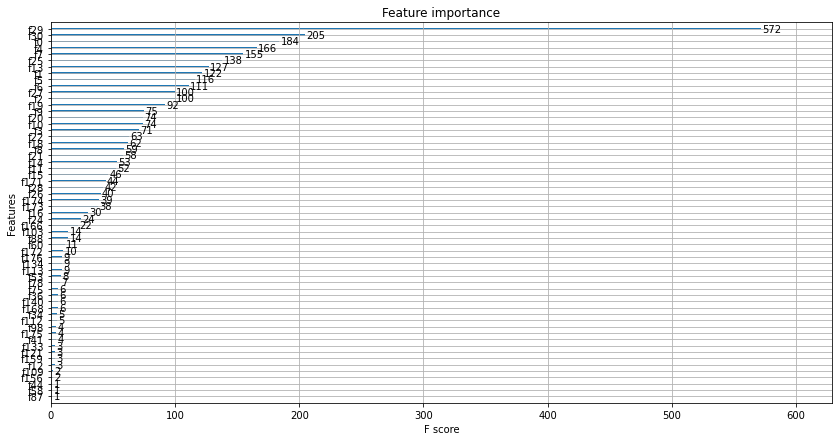

In [113]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
# plot feature importance
plt.rcParams["figure.figsize"] = (14, 7)
plot_importance(boost)

### Feature permutation

In [75]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(boost, X_test, y_test)

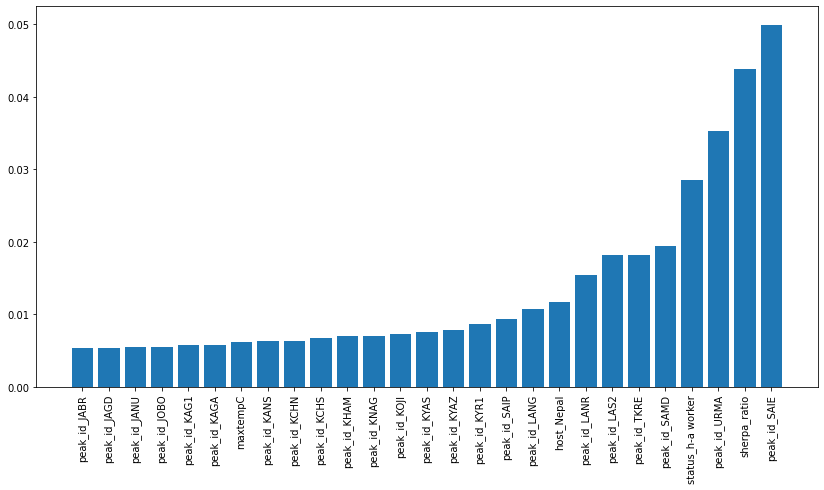

In [85]:
sorted_idx = perm_importance.importances_mean.argsort()

Y = list(sorted_idx)
sorted_feat = [x for _,x in sorted(zip(Y,feature_names))]

dfeat_prem = pd.DataFrame(data=perm_importance.importances_mean[sorted_idx])
dfeat_prem['feature'] = sorted_feat
dfeat_prem.columns = ['value', 'feature']
dfeat_prem = dfeat_prem.sort_values(by='value')


val = 0.005
# plot
plt.bar(dfeat_prem.loc[dfeat_prem['value']> val , 'feature'], dfeat_prem.loc[dfeat_prem['value']> val , 'value'])
plt.xticks(rotation=90)
plt.show()

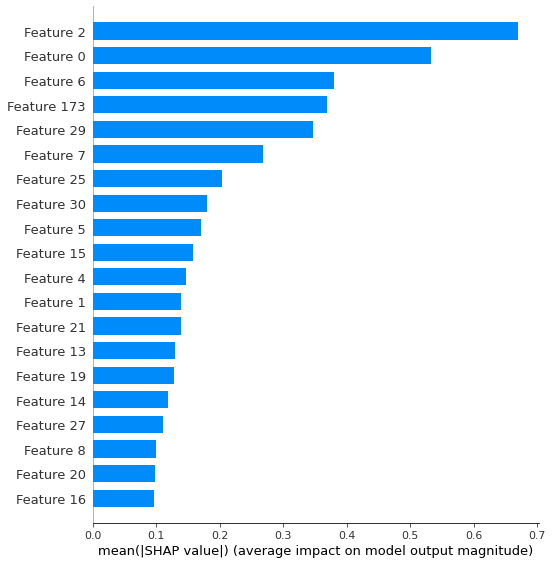

In [94]:
import shap
explainer = shap.TreeExplainer(boost)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

In [98]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_tr[0,:])

## Other Models

In [6]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression(max_iter=500)
reg.fit(X_train, y_train)
ypred = reg.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

       False       0.73      0.76      0.75      2290
        True       0.69      0.66      0.68      1852

    accuracy                           0.72      4142
   macro avg       0.71      0.71      0.71      4142
weighted avg       0.72      0.72      0.72      4142



In [7]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
ypred = clf.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

       False       0.83      0.81      0.82      2290
        True       0.77      0.80      0.79      1852

    accuracy                           0.81      4142
   macro avg       0.80      0.81      0.80      4142
weighted avg       0.81      0.81      0.81      4142



## RandomSearchCV

### XGB

In [8]:
%%time
from sklearn.model_selection import RandomizedSearchCV

params = {'booster' : ['gbtree', 'gblinear'],
        'min_child_weight': [0.1, 1, 5, 10, 50],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [5, 10, 25, 50],
        'learning_rate': [0.0001, 0.001, 0.1, 1],
        'n_estimators': [50, 100, 250, 500],
        'reg_alpha': [0.0001, 0.001, 0.1, 1],
        'reg_lambda': [0.0001, 0.001, 0.1, 1]
        }

model = XGBClassifier()

random_search = RandomizedSearchCV(model, 
                                   cv=5,
                                   param_distributions=params,  
                                   scoring='accuracy', 
                                   n_jobs=-1,
                                   verbose=1, 
                                   random_state=1001)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.9min finished


Wall time: 1min 58s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                   param_distributions={'booster': ['gbtree', 'gblinear'],
                                        'colsample_bytree': [0.6, 0.8, 1.0],
                             

In [9]:
boost

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [10]:
best_model = random_search.best_estimator_
best_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=25,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0.1, reg_lambda=0.0001, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [11]:
ypred = best_model.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

       False       0.86      0.81      0.84      2290
        True       0.78      0.84      0.81      1852

    accuracy                           0.82      4142
   macro avg       0.82      0.82      0.82      4142
weighted avg       0.83      0.82      0.82      4142



### RFC

In [12]:
%%time
from sklearn.model_selection import RandomizedSearchCV

params = {'n_estimators' : [100,200,500],
        'criterion' : ['gini', 'entropy'],
        'min_samples_split': [2, 3, 5],
        'max_depth': [5, 10, 25, 50],
        'min_samples_leaf': [1, 3, 5],
        'max_features': ["sqrt", "log2"]
        }

model = RandomForestClassifier()

random_search = RandomizedSearchCV(model, 
                                   cv=5,
                                   param_distributions=params,  
                                   scoring='accuracy', 
                                   n_jobs=-1,
                                   verbose=1, 
                                   random_state=1001)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.3s finished


Wall time: 26.3 s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 25, 50],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 3, 5],
                                        'min_samples_split': [2, 3, 5],
                                        'n_estimators': [100, 200, 500]},
                   random_state=1001, scoring='accuracy', verbose=1)

In [13]:
best_model = random_search.best_estimator_

In [14]:
best_model

RandomForestClassifier(criterion='entropy', max_depth=25, max_features='log2',
                       min_samples_split=5, n_estimators=200)

In [15]:
ypred = best_model.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

       False       0.85      0.81      0.83      2290
        True       0.78      0.83      0.80      1852

    accuracy                           0.82      4142
   macro avg       0.81      0.82      0.82      4142
weighted avg       0.82      0.82      0.82      4142



# Test xgb_model.py

In [1]:
from xgb_model import HimalXGB

model = HimalXGB().train_model()

In [2]:
y_pred = HimalXGB().predict_model(X)

NameError: name 'X' is not defined

In [ ]:
print(classification_report(y, y_pred))

# Model without weather

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from members import Members
from expeds import Expeds


# Get Data
member = Members().get_data()
member = Members().clean_data(member)

exped = Expeds().get_data()
exped = Expeds().clean_data(exped)

# Drop columns
mem_to_drop = ['memb_id','year','unique_id','peak_id','residence','occupation',
'summit_claimed','summit_disputed','highpt','high_point','death','death_type',
'death_height','death_class','summit_bid','summit_term','summit_date1',
'citizenship','o2_climb','o2_descent','o2_sleep','o2_medical', 'o2_none', 
'yob', 'route1', 'ascent1', 'leader', 'deputy', 'bconly', 'nottobc', 'support', 
'hired', 'sherpa', 'tibetan']


exp_to_drop = ['year','season','route1','route2','nation','leaders',
'sponsor','success1','success2', 'ascent1','claimed','disputed',
'countries','summit_time','term_date','term_note','high_point',
'traverse','ski','parapente','o2_climb','o2_descent','o2_sleep',
'o2_medical','o2_taken','o2_unkwn','o2_used','o2_none','other_smts',
'campsites','accidents','achievment','agency','peak_name','primmem',
'summiter_deaths','summit_members','summit_hired','hired_deaths']

member.drop(columns= mem_to_drop, inplace=True)
exped.drop(columns= exp_to_drop, inplace=True)

# Feature Engineering (1/2)
exped['sherpa_ratio'] = exped['tot_hired'] / exped['tot_members']
exped['sherpa_ratio'] = np.where(exped['sherpa_ratio'] == np.inf, 0, exped['sherpa_ratio'])


# Merge DataFrames
df = exped.merge(member, on='exp_id', how = 'right')


df.drop(columns=['summit_date', 'exp_id', 'bc_date', 'term_reason'], inplace=True)

In [5]:
# Data Processing
col_num = []
col_bool =[]
col_object =[]

for col in df:
    if df[col].dtype == "float64":
        col_num.append(col)
        
    if df[col].dtype == "int64":
        col_num.append(col)
        
    if df[col].dtype == 'bool':
        col_bool.append(col)
        
    if df[col].dtype == 'object':
        col_object.append(col)
        
col_bool.remove('summit_success')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop= 'first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, col_num),
        ('cat', categorical_transformer, col_object)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])

X = df.drop(columns=['summit_success'])
y = df.summit_success

X_trans = clf.fit_transform(X)
X_tr = X_trans.toarray()

X_train, X_test, y_train, y_test = train_test_split(X_tr, y, test_size= 0.3, random_state= 1)

In [6]:
# Model Traning
from sklearn.metrics import classification_report
boost = XGBClassifier()
boost.fit(X_train, y_train)
ypred = boost.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

       False       0.83      0.82      0.83      2792
        True       0.77      0.78      0.78      2123

    accuracy                           0.81      4915
   macro avg       0.80      0.80      0.80      4915
weighted avg       0.81      0.81      0.81      4915



# Peaks GPS

In [66]:
import pandas as pd

#gps = pd.read_excel('data/Peaks_GPS.xls')

gps = pd.read_excel('data/main_peaks.xlsx')

In [68]:
import re

def coord(x):
    numbers = re.findall(r'\d+', x)
    unit = int(numbers[0])
    dec = int(numbers[1])/60
    cent = int(numbers[2])/3600
    
    return round(unit+dec+cent,4)

In [70]:
gps['lat'] = gps['lat'].apply(lambda x: coord(x))
gps['lon'] = gps['lon'].apply(lambda x: coord(x))

In [74]:
import folium

m = folium.Map(
    location=[27.98, 86.92],
    zoom_start=8,
    tiles='Stamen Terrain'
)

feature_group = folium.FeatureGroup("Locations")
for lat, lng, name in zip(gps.lat, gps.lon, gps.peak_name):
    feature_group.add_child(folium.Marker(location=[lat,lng], popup=name))

m.add_child(feature_group)

folium.Marker(
    location=[27.948056, 86.810278],
    popup='Weather Station',
    icon=folium.Icon(color='red', icon='info-sign')
).add_to(m)


m

# Dash

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from data import Data

app = dash.Dash(__name__)

# ------------------------------------------------------------------------------
# Import and clean data (importing csv into pandas)
df = Data().get_matching_table()

mylist = df.peak_id.unique()
peak_list = pd.DataFrame({'peak' : mylist})

# ------------------------------------------------------------------------------
# App layout
app.layout = html.Div([

    html.H1("HimalayApp", style={'text-align': 'center'}),

    dcc.RangeSlider(
        id='year_slider',
        min=2010,
        max=2020,
        step=1,
        value=[2010, 2020],
        marks= {i : str(i) for i in range(2010, 2021)}),

    html.Div(id='output_container', children=[]),
    html.Br(),

    dcc.Dropdown(
        id='dropdown',
        options=[{'label':i, 'value':i} for i in peak_list['peak']]),

    html.Div(id='output', children=[]),
    html.Br(),

    html.Div(html.Iframe(src = "https://fatmap.com/around/Mount_Everest/China/@27.9967433,86.9117653,28274.0557688,-63.6300764,0.4395348,7406.1808273,normal"))
])


# # ------------------------------------------------------------------------------
# # Connect the Plotly graphs with Dash Components
# @app.callback(
#     [Output(component_id='output_container', component_property='children'),
#      Output(component_id='output', component_property='children')],
#     [Input(component_id='year_slider', component_property='value')])



# # ------------------------------------------------------------------------------
__name__ == '__main__'
app.run_server(debug=True)

KeyboardInterrupt: 

In [ ]:
url = "https://fatmap.com/routeid/339173/camp-one-to-camp-two-and-three?fmid=em"
app.layout = html.Div([
    html.Embed(src=url,width="750",height="400"),
    html.Div(id='my-div')
])


@app.callback(
    Output(component_id='my-div', component_property='children')
)

app.run_server("inline",port=8060)